### Load libraries

In [1]:
# Importing auxiliary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pylab as plt  # data plotting
import matplotlib as mpl

# styling plots
plt.style.use('dark_background')
mpl.rcParams['axes.facecolor'] = '#111111'
mpl.rcParams['figure.facecolor'] = '#111111'

# import pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


# import tensorboard for logging
from torch.utils.tensorboard import SummaryWriter

# importing local code
import sys
sys.path.append('../')
from datasets import SpectraDataset
from models import FlexibleInverseMLP
from loops import train_inverse,val_inverse

### Prepare datasets

#### Load data into dataframe and clean them

In [2]:
# filename
filename = '../DL-Assisted-NHA-Inverse-Design-/Dataset 6655.csv'

# load in dataframe
df = pd.read_csv(filename)

# clean and rearrange data
df['Spectra'] = df.values[:,5:][:,::-1].tolist()
df['Spectra'] = df['Spectra'].apply(np.array)
df.drop(df.columns[5:-1], axis=1, inplace=True)
df.columns = ['Lattice','Material','Thickness','Radius','Pitch','Spectra']

#### Split dataframe in train/val and features/labels (X/y) 

In [3]:
# select input features (y)
X_df = df["Spectra"]

# select and normalize output labels (X)
y_df = df[["Lattice", "Material", "Thickness", "Radius", "Pitch"]]
t_max, r_max, p_max = (
    y_df["Thickness"].max(),
    y_df["Radius"].max(),
    y_df["Pitch"].max(),
)
y_df["Thickness"] = y_df["Thickness"] / t_max
y_df["Radius"] = y_df["Radius"] / r_max
y_df["Pitch"] = y_df["Pitch"] / p_max

# split in training and validation set
test_val_split = 0.1  # portion of data assigned to validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_df, y_df, test_size=test_val_split, random_state=42
)

/tmp/ipykernel_1989912/2671278664.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df["Thickness"] = y_df["Thickness"] / t_max
/tmp/ipykernel_1989912/2671278664.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df["Radius"] = y_df["Radius"] / r_max
/tmp/ipykernel_1989912/2671278664.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [4]:
X_train

4851    [0.0177678, 0.0183766, 0.0188949, 0.0193357, 0...
604     [0.0605793, 0.0606152, 0.05966, 0.0578818, 0.0...
3891    [0.808406, 0.809849, 0.809093, 0.813381, 0.814...
4817    [0.0190139, 0.0184199, 0.0178838, 0.0173684, 0...
4047    [0.0225713, 0.0216366, 0.020792, 0.0200721, 0....
                              ...                        
3772    [0.859133, 0.864281, 0.86973, 0.871492, 0.8704...
5191    [0.0287532, 0.0295561, 0.0304197, 0.0313051, 0...
5226    [0.00877991, 0.00827171, 0.00775168, 0.0072616...
5390    [0.0210184, 0.0225432, 0.0239345, 0.0252061, 0...
860     [0.00322914, 0.003215, 0.00319104, 0.00315318,...
Name: Spectra, Length: 5988, dtype: object

In [5]:
X_val

5896    [0.0211472, 0.0229053, 0.0245804, 0.0261867, 0...
217     [0.0477382, 0.0480398, 0.0481729, 0.0483546, 0...
3214    [0.984692, 0.986608, 0.988734, 0.986776, 0.989...
4516    [0.019098, 0.0185224, 0.0178235, 0.0170732, 0....
1544    [0.0949851, 0.0943849, 0.0933566, 0.0924849, 0...
                              ...                        
425     [0.0150305, 0.0148046, 0.014522, 0.0143151, 0....
4382    [0.0157072, 0.016587, 0.0175634, 0.0185691, 0....
1002    [0.00339143, 0.00332585, 0.00328501, 0.0032520...
681     [0.0225218, 0.022542, 0.0223468, 0.021951, 0.0...
5719    [0.0261101, 0.0269595, 0.0279326, 0.0289608, 0...
Name: Spectra, Length: 666, dtype: object

In [6]:
y_train

,Lattice,Material,Thickness,Radius,Pitch
4851,1,0,0.900000,0.700000,0.914286
604,0,0,0.833333,0.666667,0.904762
3891,0,2,1.000000,0.333333,0.990476
4817,1,0,0.866667,0.966667,0.904762
4047,1,0,0.666667,0.833333,0.904762
...,...,...,...,...,...
3772,0,2,0.966667,0.366667,0.904762
5191,1,0,0.966667,1.000000,0.904762
5226,1,0,1.000000,0.733333,0.923810
5390,1,1,0.666667,0.866667,0.914286


In [7]:
y_val

,Lattice,Material,Thickness,Radius,Pitch
5896,1,1,0.800000,0.933333,0.914286
217,0,0,0.700000,0.566667,0.990476
3214,0,2,0.800000,0.500000,0.933333
4516,1,0,0.800000,0.766667,0.971429
1544,0,1,0.700000,0.566667,0.952381
...,...,...,...,...,...
425,0,0,0.766667,0.466667,0.980952
4382,1,0,0.766667,0.733333,0.952381
1002,0,0,0.933333,0.400000,0.923810
681,0,0,0.833333,0.533333,0.904762


#### Create datasets

In [8]:
# instantiate training and validation dataset
training_dataset = SpectraDataset(X_train,y_train,direction='inverse')
val_dataset = SpectraDataset(X_val,y_val,direction='inverse')

#### Create dataloaders

In [9]:
# batch size
batch_size = 64

# Create data loaders
train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle= True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)

for X, y in val_dataloader:
    print(f"Shape of X [N, C]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C]: torch.Size([64, 200])
Shape of y: torch.Size([64, 5]) torch.float32


### Training

#### Choosing training device: cpu, gpu, etc...

In [10]:
# Get cpu or gpu device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


#### Define model

In [11]:
# structure of the neural network
hidden_layers = [200, 500, 500, 500, 500, 500, 2, 3, 3]

# instantiate model
model = FlexibleInverseMLP(hidden_layers=hidden_layers, activation=nn.GELU(), p=0.1).to(device)

#### Defining loss and optimizer

In [12]:
# base learning rate
lr = 1.1e-4

# defining loss and optimizer
loss_reg = nn.MSELoss()
loss_ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

#### Run optimization loop

In [13]:
# create timestamp
now = datetime.now()  # current date and time
date_time = now.strftime("%d%m%y_%H%M%S")

# create summary writer for tensorboard
writer_path = '../tb_logs/inverse_' + date_time + '/'
writer = SummaryWriter(writer_path)

# loop over epochs
epochs = 2500
epoch_threshold = 500
save_checkpoint = './best_inverse_model_' + date_time + '.ckpt'
best_loss = 1.0
for epoch in range(epochs):

    # log epoch to console
    print(f"Epoch {epoch+1}\n-------------------------------")

    # perform training and validation loops: one single pass over the dataset
    train_loss = train_inverse(train_dataloader, model, loss_reg, loss_ce, optimizer, device)
    val_loss = val_inverse(val_dataloader, model, loss_reg, loss_ce, device)

    # log training and validation loss to tensorboard
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)

    # save checkpoint
    if (val_loss < best_loss) and (epoch>epoch_threshold):
        
        # save checkpoint
        model.train()
        torch.save(model.state_dict(), save_checkpoint)
        best_loss = val_loss

# close connection to tensorboard
writer.flush()
writer.close()

# finished
print("Done!")

Epoch 1
-------------------------------
Train loss: 5.208142  [   64/ 5988]
Train loss: 4.507060  [ 1344/ 5988]
Train loss: 3.988052  [ 2624/ 5988]
Train loss: 3.168921  [ 3904/ 5988]
Train loss: 2.157705  [ 5184/ 5988]


Validation loss: 1.484751 

Epoch 2
-------------------------------
Train loss: 1.790399  [   64/ 5988]
Train loss: 1.802404  [ 1344/ 5988]
Train loss: 1.362172  [ 2624/ 5988]
Train loss: 1.364448  [ 3904/ 5988]
Train loss: 1.220978  [ 5184/ 5988]


Validation loss: 1.112507 

Epoch 3
-------------------------------
Train loss: 1.275507  [   64/ 5988]
Train loss: 1.131632  [ 1344/ 5988]
Train loss: 1.205964  [ 2624/ 5988]
Train loss: 1.217380  [ 3904/ 5988]
Train loss: 1.155136  [ 5184/ 5988]


Validation loss: 1.038724 

Epoch 4
-------------------------------
Train loss: 1.197369  [   64/ 5988]
Train loss: 1.207833  [ 1344/ 5988]
Train loss: 1.103039  [ 2624/ 5988]
Train loss: 1.134508  [ 3904/ 5988]
Train loss: 1.193107  [ 5184/ 5988]


Validation loss: 0.977953 



### Model inference

In [13]:
# Instantiate inference model and set to evaluation mode
save_checkpoint ='best_inverse_model_080924_114446.ckpt'
model_inference = FlexibleInverseMLP(hidden_layers=hidden_layers, activation=nn.GELU(), p=0.1).to(
    device)
model_inference.load_state_dict(torch.load(save_checkpoint,weights_only=True))
model_inference.eval()

FlexibleInverseMLP(
  (layers): ModuleList(
    (0): BaseBlock(
      (linear): Linear(in_features=200, out_features=500, bias=False)
      (dropout): Dropout(p=0.1, inplace=False)
      (activation): GELU(approximate='none')
    )
    (1-4): 4 x BaseBlock(
      (linear): Linear(in_features=500, out_features=500, bias=False)
      (dropout): Dropout(p=0.1, inplace=False)
      (activation): GELU(approximate='none')
    )
  )
  (lattice_head): LinearBlock(
    (linear): Linear(in_features=500, out_features=2, bias=False)
  )
  (material_head): LinearBlock(
    (linear): Linear(in_features=500, out_features=3, bias=False)
  )
  (geometry_head): LinearBlock(
    (linear): Linear(in_features=500, out_features=3, bias=False)
  )
)

In [14]:
# compute inference on all validation samples
X_inference = torch.tensor(np.stack(X_val.to_numpy()).astype(np.float32)).to(device)
y_inf_lattice, y_inf_material, y_inf_geometry = model_inference(X_inference)
y_true = torch.tensor(y_val.to_numpy().astype(np.float32)).to(device)

# formatting true values for each classification and regression task
y_true_lattice = y_true[:, 0].type(torch.LongTensor).detach().cpu()
y_true_material = y_true[:, 1].type(torch.LongTensor).detach().cpu()
y_true_geometry = (
    torch.stack((y_true[:, 2] * t_max, y_true[:, 3] * r_max, y_true[:, 4] * p_max))
    .T.detach()
    .cpu()
)

# formatting predicted values for each classification and regression task
y_pred_lattice = (
    torch.argmax(torch.nn.functional.softmax(y_inf_lattice, dim=-1), dim=-1)
    .detach()
    .cpu()
)
y_pred_material = (
    torch.argmax(torch.nn.functional.softmax(y_inf_material, dim=-1), dim=-1)
    .detach()
    .cpu()
)
y_pred_geometry = (
    torch.stack(
        (
            y_inf_geometry[:, 0] * t_max,
            y_inf_geometry[:, 1] * r_max,
            y_inf_geometry[:, 2] * p_max,
        )
    )
    .T.detach()
    .cpu()
)

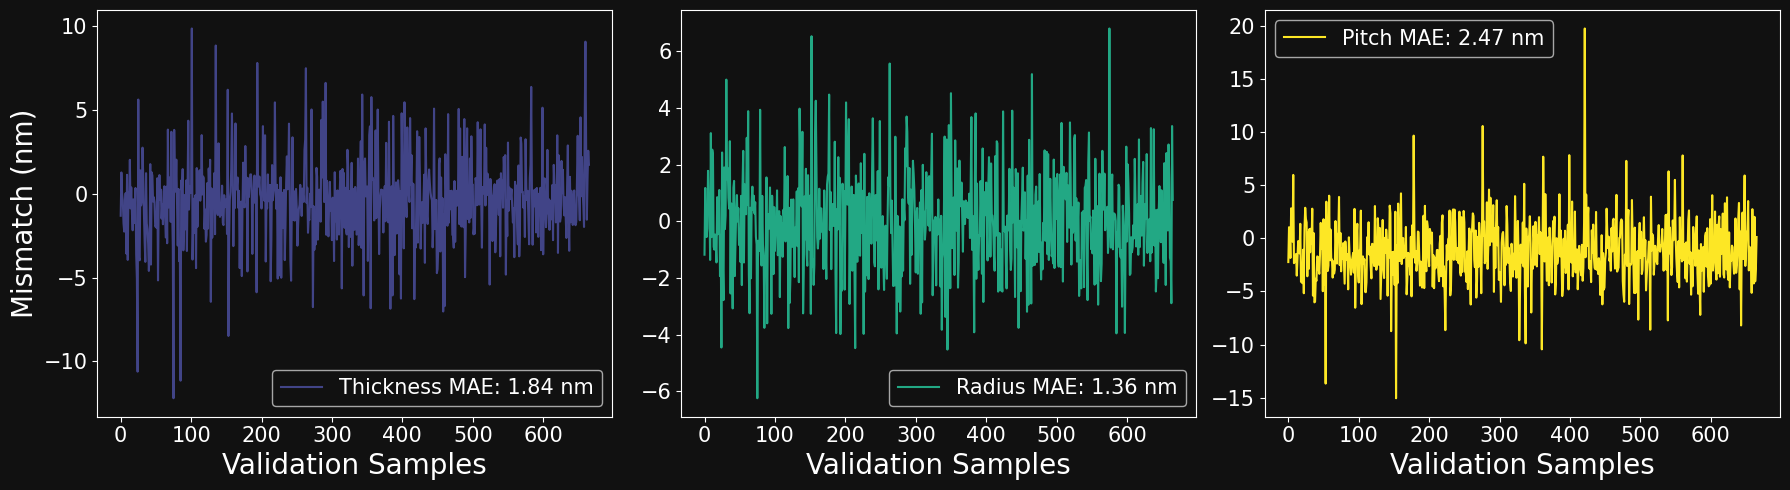

In [20]:
# setup figure
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
colors = plt.cm.viridis(np.linspace(0.2, 1, 3))
f_size = 20

# compute mean absolute error to use in the legend
t_mae = torch.round(torch.abs(y_true_geometry[:, 0] - y_pred_geometry[:, 0]).mean(), decimals=2)
r_mae = torch.round(torch.abs(y_true_geometry[:, 1] - y_pred_geometry[:, 1]).mean(), decimals=2)
p_mae = torch.round(torch.abs(y_true_geometry[:, 2] - y_pred_geometry[:, 2]).mean(), decimals=2)
legend_str = [
    "Thickness MAE: " + str(t_mae.detach().numpy()) + " nm",
    "Radius MAE: " + str(r_mae.detach().numpy()) + " nm",
    "Pitch MAE: " + str(p_mae.detach().numpy()) + " nm",
]

for i in range(3):

    # plot
    axs[i].plot(
        y_true_geometry[:, i] - y_pred_geometry[:, i],
        label=legend_str[i],
        color=colors[i],
    )

    # labels
    axs[i].set_xlabel("Validation Samples", fontsize=f_size)
    if i == 0:
        axs[i].set_ylabel("Mismatch (nm)", fontsize=f_size)

    # ticks
    axs[i].tick_params(labelsize=f_size - 5)

    # legend
    axs[i].legend(fontsize=f_size - 5)

fig.set_tight_layout("tight")

In [21]:
y_true_lattice - y_pred_lattice

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [22]:
y_true_material - y_pred_material

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,